In [1]:
!pip install torch>=1.13.0+cu116 torchvision>=0.13.0+cu116 torchaudio>=0.13.0 --extra-index-url https://download.pytorch.org/whl/cu116

In [3]:
!pip install numpy pandas nltk

  Using cached pandas-2.2.2-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached nltk-3.8.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached joblib-1.4.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached regex-2023.12.25-cp312-cp312-win_amd64.whl.metadata (41 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
Using cached pandas-2.2.2-cp312-cp312-win_amd64.whl (11.5 MB)
Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached regex-2023.12.25-cp312-cp312-win_amd64.whl (268 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Using cached joblib-1.4.0-py3-none-any.whl (301 kB)
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)


In [4]:

import numpy as np
import pandas as pd 


import os
for dirname, _, filenames in os.walk(r'C:\Users\insid\OneDrive\Desktop\Project DL'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\insid\OneDrive\Desktop\Project DL\0.13.0
C:\Users\insid\OneDrive\Desktop\Project DL\0.21.0
C:\Users\insid\OneDrive\Desktop\Project DL\bert.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\cnn-lstm.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\IMDB Dataset.csv
C:\Users\insid\OneDrive\Desktop\Project DL\LSTM.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\Research_Paper_LSTM_Densenet_embedding.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\RNN.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\visualization.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\.venv\.gitignore
C:\Users\insid\OneDrive\Desktop\Project DL\.venv\pyvenv.cfg
C:\Users\insid\OneDrive\Desktop\Project DL\.venv\Lib\site-packages\decorator.py
C:\Users\insid\OneDrive\Desktop\Project DL\.venv\Lib\site-packages\ipykernel_launcher.py
C:\Users\insid\OneDrive\Desktop\Project DL\.venv\Lib\site-packages\isympy.py
C:\Users\insid\OneDrive\Desktop\Project DL\.venv\Lib\site-packages\jupyter.py
C:\Users\insid\OneDrive\De

In [11]:
!pip uninstall torch

^C


In [9]:
!pip3  torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [10]:
print(torch.__version__)


2.2.2+cpu


In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Setting device to GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Setting device to CPU.")

CUDA is available. Setting device to GPU.


In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import pandas as pd


imdb_csv = r'C:\Users\insid\OneDrive\Desktop\Project DL\IMDB Dataset.csv'


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
   
    tokens = word_tokenize(text.lower())
   
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)


def load_imdb_dataset(csv_file):
    df = pd.read_csv(csv_file)
    reviews = []
    for _, row in df.iterrows():
        review = row['review']
        sentiment = 1 if row['sentiment'] == 'positive' else 0
        preprocessed_review = preprocess_text(review)
        reviews.append((preprocessed_review, sentiment))
    return reviews


class IMDBDataset(Dataset):
    def __init__(self, reviews, vocab_size=10000):
        self.reviews = reviews
        self.vocab_size = vocab_size
        self.word_to_idx = self.build_vocab()
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.sequence_length = max(len(review[0].split()) for review in reviews)
        
    def build_vocab(self):
        word_counts = {}
        for review, _ in self.reviews:
            for word in review.split():
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
        
        sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)[:self.vocab_size]
        return {word: idx for idx, word in enumerate(sorted_words)}
    
    def vectorize_review(self, review):
        vector = np.zeros(self.sequence_length, dtype=np.int64)
        for i, word in enumerate(review.split()):
            if i >= self.sequence_length:
                break
            vector[i] = self.word_to_idx.get(word, 0)
        return vector
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, index):
        review, sentiment = self.reviews[index]
        review_vector = self.vectorize_review(review)
        return torch.tensor(review_vector), torch.tensor(sentiment)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\insid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import torch
import torch.nn as nn

class CNNLSTMSentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, kernel_sizes, lstm_hidden_dim, dropout):
        super(CNNLSTMSentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])
        
        self.dropout = nn.Dropout(dropout)
        
        self.lstm = nn.LSTM(input_size=num_filters * len(kernel_sizes), hidden_size=lstm_hidden_dim, batch_first=True)
        
        self.fc = nn.Linear(lstm_hidden_dim, 1)
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)  # Reshape for Conv1d
        
        conv_outputs = []
        for conv in self.convs:
            conv_output = nn.functional.relu(conv(embedded))
            conv_output = nn.functional.max_pool1d(conv_output, kernel_size=conv_output.shape[-1])
            conv_output = conv_output.squeeze(-1)
            conv_outputs.append(conv_output)
        
        conv_concat = torch.cat(conv_outputs, dim=1)
        conv_concat = self.dropout(conv_concat)
        
        lstm_output, _ = self.lstm(conv_concat.unsqueeze(1))
        lstm_output = self.dropout(lstm_output[:, -1, :])
        
        output = self.fc(lstm_output)
        return output

In [4]:
from torch.utils.data import Dataset, DataLoader, random_split


In [5]:
vocab_size = 10000
embedding_dim = 100
hidden_dim = 128
output_dim = 1
batch_size = 64
num_epochs = 10
learning_rate = 0.001

reviews = load_imdb_dataset(imdb_csv)


dataset = IMDBDataset(reviews, vocab_size)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


dataset_size = len(dataset)
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
print(device)

cuda


In [32]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

vocab_size = 10000
embedding_dim = 300
num_filters = 100
kernel_sizes = [3, 4, 5]
lstm_hidden_dim = 128
learning_rate = 0.0002
num_epochs = 10
batch_size = 64  
patience = 3  


model =CNNLSTMSentimentModel(vocab_size, embedding_dim, num_filters, kernel_sizes, lstm_hidden_dim, 0.5)

model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Added weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

best_val_loss = float('inf')
counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target.float())
        loss.backward()
        
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            loss = criterion(output, target.float())
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
 
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/10], Batch [100/547], Loss: 0.6930
Epoch [1/10], Batch [200/547], Loss: 0.7006
Epoch [1/10], Batch [300/547], Loss: 0.6453
Epoch [1/10], Batch [400/547], Loss: 0.6420
Epoch [1/10], Batch [500/547], Loss: 0.5743
Epoch [1/10], Train Loss: 0.6623, Val Loss: 0.5474
Epoch [2/10], Batch [100/547], Loss: 0.5454
Epoch [2/10], Batch [200/547], Loss: 0.5929
Epoch [2/10], Batch [300/547], Loss: 0.6291
Epoch [2/10], Batch [400/547], Loss: 0.4427
Epoch [2/10], Batch [500/547], Loss: 0.4020
Epoch [2/10], Train Loss: 0.5467, Val Loss: 0.4469
Epoch [3/10], Batch [100/547], Loss: 0.3916
Epoch [3/10], Batch [200/547], Loss: 0.5392
Epoch [3/10], Batch [300/547], Loss: 0.4751
Epoch [3/10], Batch [400/547], Loss: 0.4471
Epoch [3/10], Batch [500/547], Loss: 0.5427
Epoch [3/10], Train Loss: 0.4734, Val Loss: 0.3959
Epoch [4/10], Batch [100/547], Loss: 0.6085
Epoch [4/10], Batch [200/547], Loss: 0.3150
Epoch [4/10], Batch [300/547], Loss: 0.4356
Epoch [4/10], Batch [400/547], Loss: 0.4022
Epoch [4/10

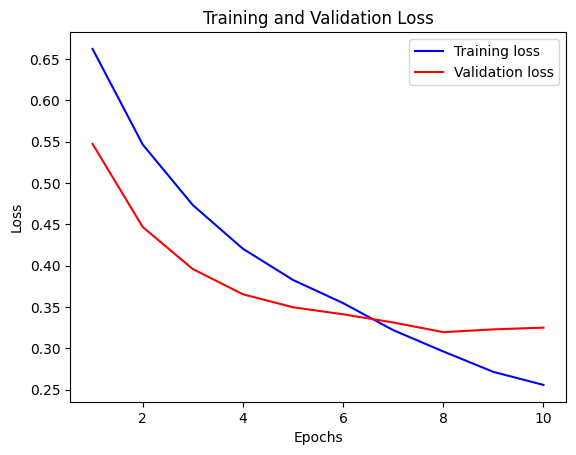

In [33]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [34]:

model.eval()  
total = 0
correct = 0
with torch.no_grad(): 
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data).squeeze()
        predictions = torch.sigmoid(output) >= 0.5  
        total += target.size(0)
        correct += (predictions == target).sum().item()

accuracy = correct / total

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 87.65%


In [35]:
def predict_sentiment(model, sentence, dataset):
    model.eval()

    preprocessed_sentence = preprocess_text(sentence)
    
  
    vectorized_sentence = dataset.vectorize_review(preprocessed_sentence)
    vectorized_sentence = torch.tensor(vectorized_sentence).unsqueeze(0).to(device)
   
    with torch.no_grad():
        output = model(vectorized_sentence)
        predicted = torch.sigmoid(output).item()

    sentiment = 'Positive' if predicted >= 0.6 else 'Negative'
    confidence = predicted if predicted >= 0.6 else 1 - predicted
    
    return sentiment, confidence


sentences = [
    "This movie was fantastic! The acting was superb and the plot kept me engaged throughout.",
    "I was really disappointed with this book. The characters were poorly developed and the story was predictable.",
    "The restaurant had great ambiance, but the food was mediocre at best.",
    "I absolutely loved this song! It's catchy and the lyrics are meaningful."
]

for sentence in sentences:
    sentiment, confidence = predict_sentiment(model, sentence, dataset)
    print(f'Sentence: {sentence}')
    print(f'Predicted Sentiment: {sentiment}')
    print(f'Confidence: {confidence:.2f}')
    print('---')

Sentence: This movie was fantastic! The acting was superb and the plot kept me engaged throughout.
Predicted Sentiment: Positive
Confidence: 0.97
---
Sentence: I was really disappointed with this book. The characters were poorly developed and the story was predictable.
Predicted Sentiment: Negative
Confidence: 1.00
---
Sentence: The restaurant had great ambiance, but the food was mediocre at best.
Predicted Sentiment: Positive
Confidence: 0.67
---
Sentence: I absolutely loved this song! It's catchy and the lyrics are meaningful.
Predicted Sentiment: Positive
Confidence: 1.00
---
